In [1]:
import requests
import time
import pandas as pd
import numpy as np
import psycopg2
import sqlalchemy
from dotenv import load_dotenv
import os

load_dotenv()

True

### Verbindung zur Datenbank aufbauen und Daten aus der Tabelle laden

In [2]:
host = os.getenv('HOST')
port = os.getenv('PORT')
user = os.getenv('USER')
password = os.getenv('PASSWORD')
database= os.getenv('DATABASE')

In [3]:
# Verbindung zur Datenbank herstellen
connection = psycopg2.connect(host=host, port=port, database=database, user=user, password=password)
print("Verbindung zur Datenbank erfolgreich hergestellt.")

# Einen Cursor erstellen, um SQL-Abfragen auszuführen
cursor = connection.cursor()

# SQL SELECT-Abfrage
select_query = "SELECT * FROM value;"

# Abfrage ausführen
cursor.execute(select_query)

# Ergebnis abrufen
rows = cursor.fetchall()

# Ergebnis in ein Pandas DataFrame umwandeln
df = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])

# Cursor und Verbindung schließen
cursor.close()
connection.close()


Verbindung zur Datenbank erfolgreich hergestellt.


In [5]:
# Sicherstellen, dass 'time' als Datetime-Objekt erkannt wird
df['time'] = pd.to_datetime(df['time'])

### Random Forest Modell

In [5]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


# 1. Convert the time column to datetime objects
df['time'] = pd.to_datetime(df['time'])

# 2. Feature Engineering with Lags
lags = [1, 2, 3]  # Lags for 10, 20, and 30 minutes
for lag in lags:
    df[f'Temperatur_lag_{lag*10}'] = df.groupby('senseid_fk')['temperature'].shift(lag)

# 3. Create target variables for each prediction horizon
for minutes in [10, 20, 30]:
    shift = minutes // 10  # Calculate the shift based on 10-minute intervals
    df[f'Temperatur_in_{minutes}_Minuten'] = df.groupby('senseid_fk')['temperature'].shift(-shift)

# 4. Remove rows with missing values (introduced by lagging and shifting)
df.dropna(inplace=True)

In [8]:
# 5. Define target variables and create a dictionary for models
target_variables = ['Temperatur_in_10_Minuten', 'Temperatur_in_20_Minuten', 'Temperatur_in_30_Minuten']
models = {}

# 6. Train and evaluate models for each target variable
for target in target_variables:
    # 6.1. Select features and target variable
    X = df.drop(target_variables + ["time", "senseid_fk"], axis=1)
    y = df[target]

    # 6.2. Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 6.3. Create and train the Random Forest model
    model = RandomForestRegressor(n_estimators=400,max_depth=40, random_state=42)
    model.fit(X_train, y_train)

    # 6.4. Make predictions and evaluate
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"\n{target}:")
    print(f"  Mean Squared Error: {mse}")
    print(f"  Mean Absolute Error: {mae}")

    # 6.5. Store the trained model
    models[target] = model


Temperatur_in_10_Minuten:
  Mean Squared Error: 0.6959775182910382
  Mean Absolute Error: 0.29405328315365437

Temperatur_in_20_Minuten:
  Mean Squared Error: 1.1561430452437964
  Mean Absolute Error: 0.42871305138224786

Temperatur_in_30_Minuten:
  Mean Squared Error: 1.5624276179679655
  Mean Absolute Error: 0.5264186126191158


### Mit GridSearch und CV

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.metrics import mean_squared_error, mean_absolute_error

# # 5. Define target variables and create a dictionary for models
# target_variables = ['Temperatur_in_10_Minuten', 'Temperatur_in_20_Minuten', 'Temperatur_in_30_Minuten']
# models = {}

# # Hyperparameter grid for Random Forest
# param_grid = {
#     'n_estimators': [300, 400],
#     'max_depth': [30, 40, 50, 60, 70],
# }

# # 6. Train and evaluate models for each target variable
# for target in target_variables:
#     # 6.1. Select features and target variable
#     X = df.drop(target_variables + ["time", "senseid_fk"], axis=1)
#     y = df[target]

#     # 6.2. Split data into training and testing sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#     # 6.3. Perform GridSearchCV to find the best hyperparameters
#     rf = RandomForestRegressor(random_state=42)
#     grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
#     grid_search.fit(X_train, y_train)

#     # 6.4. Get the best model from grid search
#     best_model = grid_search.best_estimator_

#     # 6.5. Make predictions and evaluate
#     y_pred = best_model.predict(X_test)
#     mse = mean_squared_error(y_test, y_pred)
#     mae = mean_absolute_error(y_test, y_pred)
#     print(f"\n{target}:")
#     print(f"  Best Parameters: {grid_search.best_params_}")
#     print(f"  Mean Squared Error: {mse}")
#     print(f"  Mean Absolute Error: {mae}")

#     # 6.6. Store the trained model
#     models[target] = best_model



Temperatur_in_10_Minuten:
  Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
  Mean Squared Error: 0.7231009365555813
  Mean Absolute Error: 0.29696808916272927

Temperatur_in_20_Minuten:
  Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
  Mean Squared Error: 1.1219574791632885
  Mean Absolute Error: 0.4293155597508828

Temperatur_in_30_Minuten:
  Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
  Mean Squared Error: 1.3734161227737929
  Mean Absolute Error: 0.5241237983584991


### ARIMA

In [4]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [6]:
df.head()

,index,time,temperature,luftfeuchtigkeit,pm10,pm2_5,senseid_fk
0,1,2024-05-15 16:32:38,18.30,99.90,3.40,3.10,5ae4a726223bd80019a367a6
1,2,2024-05-15 16:32:39,17.90,75.63,9.45,8.20,5dde9523ba7944001da4150e
2,3,2024-05-15 16:32:40,22.90,55.90,3.23,2.93,5c08379b1c28f9001a3f580c
3,4,2024-05-15 16:32:40,17.24,69.30,10.77,3.38,5b4d11485dc1ec001b5452c7
4,5,2024-05-15 16:32:41,26.30,30.70,0.00,0.00,65e8d93acbf5700007f920ca


In [8]:
# Daten für eine Wetterstation extrahieren
station_id = "5ae4a726223bd80019a367a6" 
station_data = df[df['senseid_fk'] == station_id]

# Sortieren nach Zeit
station_data = station_data.sort_values(by='time')

# Zeit und Temperatur als Zeitreihe
station_data.set_index('time', inplace=True)
temperature_series = station_data['temperature']

In [12]:
station_data

,index,temperature,luftfeuchtigkeit,pm10,pm2_5,senseid_fk
time,,,,,,
2023-01-14 13:25:07.618,194946,9.1,99.9,7.53,1.23,5ae4a726223bd80019a367a6
2023-01-14 13:27:38.507,194945,9.2,99.9,3.67,1.00,5ae4a726223bd80019a367a6
2023-01-14 13:30:20.783,194944,9.2,99.9,4.33,1.00,5ae4a726223bd80019a367a6
2023-01-14 13:33:03.062,194943,9.2,99.9,2.30,0.90,5ae4a726223bd80019a367a6
2023-01-14 13:35:30.628,194942,9.2,99.9,3.57,1.00,5ae4a726223bd80019a367a6
...,...,...,...,...,...,...
2024-06-05 20:00:05.000,1193304,17.1,99.9,3.90,3.03,5ae4a726223bd80019a367a6
2024-06-05 20:10:04.000,1193312,16.9,99.9,5.68,3.95,5ae4a726223bd80019a367a6
2024-06-05 20:20:04.000,1193320,16.7,99.9,7.40,3.97,5ae4a726223bd80019a367a6


<Axes: xlabel='time'>

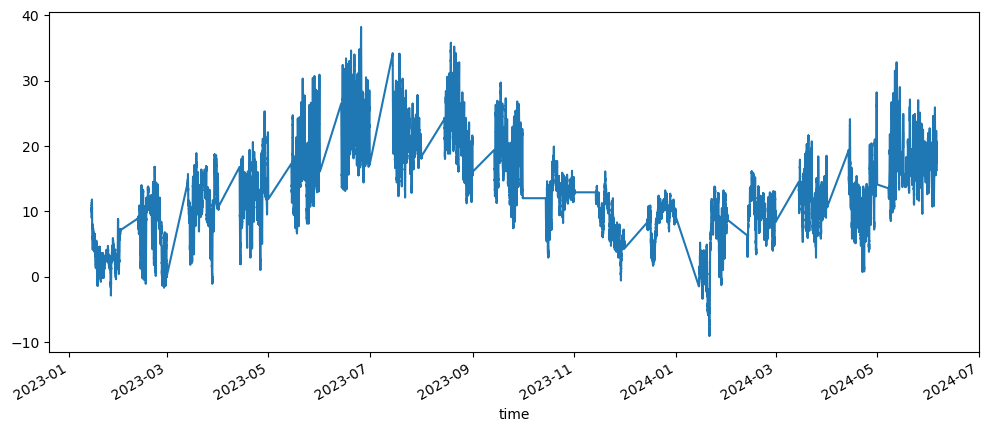

In [9]:
station_data['temperature'].plot(figsize=(12,5))

In [10]:
from statsmodels.tsa.stattools import adfuller
def adf_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
adf_test(station_data['temperature'])

1. ADF :  -12.25647105527954
2. P-Value :  9.285814742173022e-23
3. Num Of Lags :  69
4. Num Of Observations Used For ADF Regression: 171670
5. Critical Values :
	 1% :  -3.4303880928396535
	 5% :  -2.861556836515786
	 10% :  -2.566778961474706


Order für ARIMA

In [13]:
from pmdarima import auto_arima

In [14]:
stepwise_fit = auto_arima(station_data['temperature'], trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-136216.585, Time=96.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-131081.773, Time=10.63 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-131813.249, Time=13.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-131742.194, Time=14.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-131083.762, Time=4.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-136183.556, Time=82.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-136239.446, Time=108.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-136219.507, Time=50.36 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-132330.271, Time=8.63 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-136237.770, Time=113.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-132868.309, Time=10.62 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-136210.071, Time=121.34 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-136241.474, Time=25.35 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-136

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:               171740
Model:               SARIMAX(1, 1, 1)   Log Likelihood               68124.164
Date:                Wed, 05 Jun 2024   AIC                        -136242.329
Time:                        23:00:31   BIC                        -136212.167
Sample:                             0   HQIC                       -136233.392
                             - 171740                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9797      0.001   1034.698      0.000       0.978       0.982
ma.L1         -0.9446      0.001   -761.960      0.000      -0.947      -0.942
sigma2         0.0265   2.37e-06   1.12e+04      0.000       0.026       0.026
===================================================================================
Ljung-Box (L1) (Q):                   1.00   Jarque-Bera (JB):       64898273567.87
Prob(Q):                              0.32   Prob(JB):                         0.00
Heteroskedasticity (H):               2.51   Skew:                            -7.53
Prob(H) (two-sided):                  0.00   Kurtosis:                      3014.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
from statsmodels.tsa.arima.model import ARIMA

In [25]:
train=station_data.iloc[:-30]
test=station_data.iloc[-30:]
print(train.shape,test.shape)


(171710, 6) (30, 6)


In [36]:
model=ARIMA(train["temperature"],order=(1,0,5))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            temperature   No. Observations:               171710
Model:                 ARIMA(1, 0, 5)   Log Likelihood               66683.501
Date:                Wed, 05 Jun 2024   AIC                        -133351.002
Time:                        23:24:57   BIC                        -133270.574
Sample:                             0   HQIC                       -133327.173
                             - 171710                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.8668      1.396      9.215      0.000      10.130      15.603
ar.L1          0.9996   6.68e-05    1.5e+04      0.000       0.999       1.000
ma.L1          0.0522      0.001     63.125      0.000       0.051       0.054
ma.L2          0.0450      0.001     48.218      0.000       0.043       0.047
ma.L3          0.0483      0.001     50.656      0.000       0.046       0.050
ma.L4          0.0428      0.001     36.340      0.000       0.040       0.045
ma.L5          0.0424      0.001     36.924      0.000       0.040       0.045
sigma2         0.0269   3.09e-06   8705.243      0.000       0.027       0.027
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):       60607529276.23
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               2.43   Skew:                            -7.33
Prob(H) (two-sided):                  0.00   Kurtosis:                      2913.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='time'>

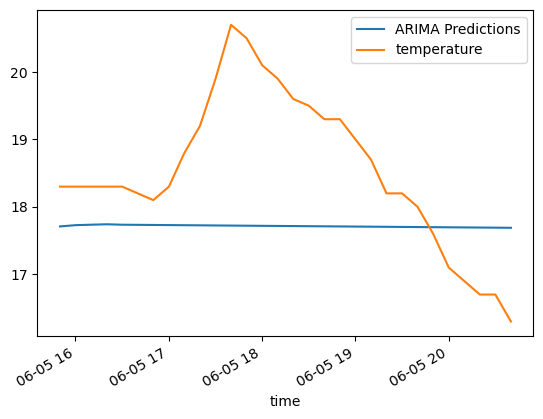

In [37]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.index=station_data.index[start:end+1]
pred.plot(legend=True)
test['temperature'].plot(legend=True)


In [38]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test['temperature'].mean()
rmse=sqrt(mean_squared_error(pred,test['temperature']))
print(rmse)

1.3822488324268412


### FÜR ARIMA SOLLTEN DIE DATEN AUF STUNDENEBENE ODER VLLT SOGAR TAGESEBENE REDUZIERT WERDEN